<a href="https://colab.research.google.com/github/dushyant3615/Mine/blob/main/Hate_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import torch
from pathlib import Path
from transformers import RobertaTokenizer

# Use a local relative path
csv_path = Path('HateSpeechDetection.csv')
train_df = pd.read_csv(csv_path)

from sklearn.model_selection import train_test_split
train_text, val_text, train_labels, val_labels = train_test_split(
    train_df['Comment'], train_df['Hateful'], test_size=0.2, random_state=42
)

train_df = pd.DataFrame({'Comment': train_text, 'Hateful': train_labels})
val_df = pd.DataFrame({'Comment': val_text, 'Hateful': val_labels})

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


def tokenize_data(data):
    return tokenizer(
        data.tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

train_tokens = tokenize_data(train_df['Comment'])
val_tokens = tokenize_data(val_df['Comment'])
train_labels = train_df['Hateful'].values
val_labels = val_df['Hateful'].values

print(train_tokens['input_ids'].shape, val_tokens['input_ids'].shape)

torch.Size([2400, 66]) torch.Size([600, 63])


In [8]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

train_dataset = [{'input_ids': train_tokens['input_ids'][i],
                  'attention_mask': train_tokens['attention_mask'][i],
                  'labels': torch.tensor(train_labels[i])}
                 for i in range(len(train_labels))]

val_dataset = [{'input_ids': val_tokens['input_ids'][i],
                  'attention_mask': val_tokens['attention_mask'][i],
                  'labels': torch.tensor(val_labels[i])}
                 for i in range(len(val_labels))]

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\dushy\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.200200,0.126271,0.958333,0.840336,0.943396,0.888889
2,0.077100,0.128591,0.966667,0.898148,0.915094,0.906542
3,0.024300,0.131539,0.970000,0.900000,0.933962,0.916667


c:\Users\dushy\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\dushy\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=450, training_loss=0.15374882380167643, metrics={'train_runtime': 3452.0706, 'train_samples_per_second': 2.086, 'train_steps_per_second': 0.13, 'total_flos': 244199948256000.0, 'train_loss': 0.15374882380167643, 'epoch': 3.0})

In [14]:
# Predict on the validation dataset
predictions = trainer.predict(val_dataset)

y_pred = predictions.predictions.argmax(-1)
y_true = val_labels


c:\Users\dushy\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [10]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=["Not Hateful", "Hateful"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

 Not Hateful       0.99      0.98      0.98       494
     Hateful       0.90      0.93      0.92       106

    accuracy                           0.97       600
   macro avg       0.94      0.96      0.95       600
weighted avg       0.97      0.97      0.97       600



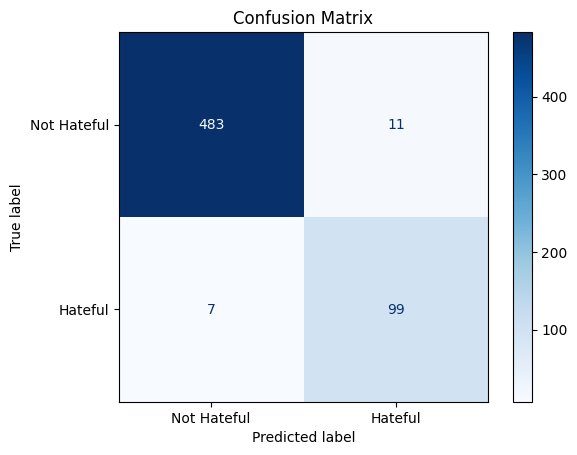

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = predictions.predictions.argmax(-1)
y_true = val_labels

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hateful", "Hateful"])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

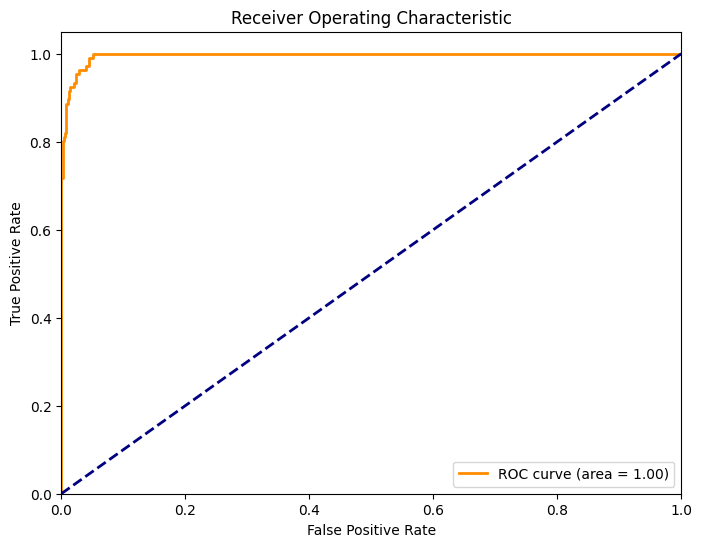

In [17]:
from sklearn.metrics import roc_curve, auc

y_probs = predictions.predictions[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [19]:
# Save model and tokenizer (Windows-friendly)
from datetime import datetime
save_root = Path('fine_tuned_roberta_hate_speech')
save_dir = save_root / datetime.now().strftime('%Y%m%d_%H%M%S')
save_dir.mkdir(parents=True, exist_ok=True)

# Avoid safetensors on Windows to prevent file lock errors
trainer.model.save_pretrained(save_dir, safe_serialization=False)
tokenizer.save_pretrained(save_dir)
print(f"Saved to: {save_dir}")

# Simple inference helper
from transformers import pipeline
text_classifier = pipeline('text-classification', model=str(save_dir), tokenizer=str(save_dir), device=0 if torch.cuda.is_available() else -1)

def predict_hate(texts):
    if isinstance(texts, str):
        texts = [texts]
    outputs = text_classifier(texts, truncation=True)
    return outputs

# Example
sample_texts = [
    "I love this community!",
    "You are disgusting and should be banned.",
]
print(predict_hate(sample_texts))


Saved to: fine_tuned_roberta_hate_speech\20250909_154626


Device set to use cpu


[{'label': 'LABEL_0', 'score': 0.9995571970939636}, {'label': 'LABEL_1', 'score': 0.9981207251548767}]


In [20]:
res = predict_hate(sample_texts)
for text, out in zip(sample_texts, res):
    label = "Hateful" if out["label"] in ("LABEL_1", "Hateful") else "Not Hateful"
    print(f"{label:12}  score={out['score']:.3f}  |  {text}")

Not Hateful   score=1.000  |  I love this community!
Hateful       score=0.998  |  You are disgusting and should be banned.
